In [21]:
import os
import random
import numpy as np
from pathlib import Path
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, explained_variance_score
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import KFold, GridSearchCV, train_test_split

from side_info_decoding.utils import load_data_from_pids

#### functionality

In [26]:
def time_bin_wise_metrics(y_true, y_pred):
    r2 = r2_score(y_true.flatten(), y_pred.flatten())
    adj_r2 = explained_variance_score(y_true, y_pred)
    return r2, adj_r2

def sliding_window_over_time(data, window_size=10):
    
    if len(data.shape) == 3:
        n_trials, n_units, n_t_bins = data.shape
        data_window = np.zeros((
            n_trials, n_units, n_t_bins - window_size + 1, window_size
        ))
        for t in range(window_size-1, n_t_bins):
            tmp_window = np.zeros((n_trials, n_units, window_size))
            for d in range(window_size):
                  tmp_window[:,:,d] = data[:,:,t - d]
            data_window[:,:,t-window_size] = tmp_window
    else:
        n_trials, n_t_bins = data.shape
        data_window = np.zeros((n_trials, n_t_bins - window_size + 1))
        for t in range(window_size-1, n_t_bins):
            data_window[:,t-window_size] = data[:,t]
    return data_window

def causal_decoder(train_X, train_Y, test_X, test_Y, verbose=True):
    penalty = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
    
    train_K, C, T, L = train_X.shape
    test_K, _, _, _ = test_X.shape
    
    train_X = train_X.transpose(0,1,-1,2).reshape(train_K, C*L, T).transpose(0,-1,1).reshape((-1, C*L))
    test_X = test_X.transpose(0,1,-1,2).reshape(test_K, C*L, T).transpose(0,-1,1).reshape((-1, C*L))
    train_Y = train_Y.reshape((-1))
    test_Y = test_Y.reshape((-1))
    
    decoder = GridSearchCV(Ridge(), {"alpha": penalty})
    decoder.fit(train_X, train_Y)
    pred_Y = decoder.predict(test_X)
    test_Y = test_Y.reshape(test_K, T)
    pred_Y = pred_Y.reshape(test_K, T)
    
    r2, adj_r2 = time_bin_wise_metrics(test_Y, pred_Y)
    if verbose:
        print(f"r2: {r2:.3f} adj-r2: {adj_r2:.3f}")
    
    return pred_Y, [r2, adj_r2]

In [23]:
class ReducedRankRegression(torch.nn.Module):    
    def __init__(self, n_c, n_t, n_r):
        super(ReducedRankRegression, self).__init__()
        self.U = torch.nn.Parameter(torch.randn(n_c, n_r))
        self.V = torch.nn.Parameter(torch.randn(n_r, n_t))
        self.b = torch.nn.Parameter(torch.randn(1,))
        self.double()
        
    def forward(self, x):
        self.beta = self.U @ self.V
        out = torch.einsum("ct,kct->kt", self.beta, x)
        out += self.b
        return out
    
def train_rrr(
    X, 
    Y, 
    train,
    test,
    n_r = 10,
    learning_rate=1e-3,
    n_epochs=10000,
    ):
    
    _, n_c, n_t = X.shape
    rrr = ReducedRankRegression(n_c, n_t, n_r)
    optimizer = torch.optim.Adam(rrr.parameters(), lr=learning_rate, weight_decay=1e-3)
    criterion = torch.nn.MSELoss()
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    train_x, test_x = X[train], X[test]
    train_y, test_y = Y[train], Y[test]
    
    losses = []
    for epoch in tqdm(range(n_epochs), desc="Train RRR:"):
        optimizer.zero_grad()
        y_pred = rrr(train_x)
        loss = criterion(y_pred, train_y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return rrr, losses

#### load data

In [4]:
pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    # "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    # "523f8301-4f56-4faf-ab33-a9ff11331118",
    # "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    # '0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a',
    # '143dd7cf-6a47-47a1-906d-927ad7fe9117',
    # '16799c7a-e395-435d-a4c4-a678007e1550',
    # '1a60a6e1-da99-4d4e-a734-39b1d4544fad',
    # '1e176f17-d00f-49bb-87ff-26d237b525f1',
    # '31f3e083-a324-4b88-b0a4-7788ec37b191'
]

In [13]:
X_dict, Y_dict = load_data_from_pids(
    pids,
    brain_region="all",
    behavior="pupil_diameter",
    data_type="all_ks",
    n_t_bins = 60,
    align_time_type="feedback_times",
    t_before=0.2,
    t_after=1.0,
    normalize_input=False
)

pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 367 (active: 367)
prior for this session is not found.
found 367 trials from 17.86 to 2310.69 sec.


Compute spike count: 100%|███████████████████| 367/367 [00:02<00:00, 159.57it/s]


In [14]:
pid = pids[0]
X, Y = X_dict[pid], Y_dict[pid]
K, C, T = X.shape
print(X.shape)
print(Y.shape)

(367, 514, 60)
(367, 60)


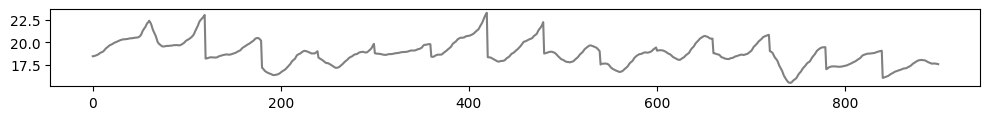

In [15]:
plt.figure(figsize=(12,1))
plt.plot(Y[10:10+15].flatten(), c="gray")
plt.show()

#### baseline

In [23]:
kf = KFold(n_splits=5, shuffle=True, random_state=666)
for train, test in kf.split(X, Y):
    pass

In [42]:
window_X = sliding_window_over_time(X, window_size=10)
window_Y = sliding_window_over_time(Y, window_size=10)
train_X, test_X = window_X[train], window_X[test]
train_Y, test_Y = window_Y[train], window_Y[test]
y_pred, metric = causal_decoder(train_X, train_Y, test_X, test_Y)

sliding-window:
r2: 0.305 corr: 0.601


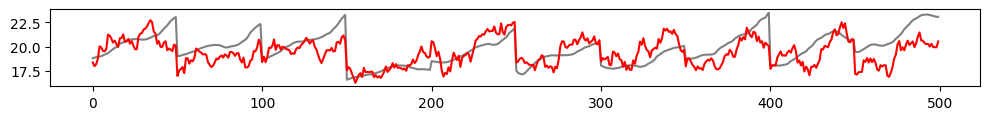

In [49]:
i = 0
plt.figure(figsize=(12,1))
plt.plot(test_Y.flatten()[i:i+500], c="gray")
plt.plot(y_pred.flatten()[i:i+500], c="r")
plt.show()

#### low-rank subspace

In [50]:
R = 10

rrr, losses = train_rrr(
    X = X,
    Y = Y, 
    train = train,
    test = test,
    n_r = R,
    learning_rate = 5e-3,
    n_epochs = 10000
)

Train RRR:: 100%|█████████████████████████| 10000/10000 [05:51<00:00, 28.44it/s]


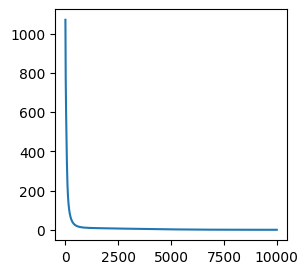

In [51]:
plt.figure(figsize=(3,3))
plt.plot(losses);

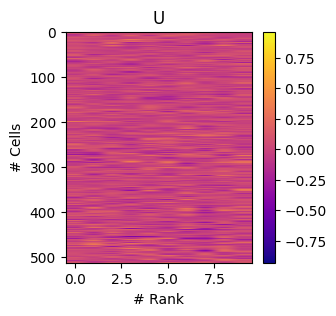

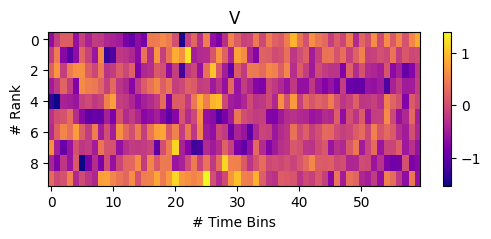

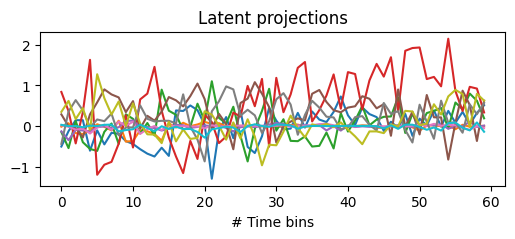

In [59]:
supervised_subspace = rrr.U.detach().numpy()
subspace_weights = rrr.V.detach().numpy()

plt.figure(figsize=(3,3))
plt.imshow(supervised_subspace, aspect="auto", cmap="plasma")
plt.title("U")
plt.xlabel("# Rank")
plt.ylabel("# Cells")
plt.colorbar()
plt.show()

plt.figure(figsize=(6,2))
plt.imshow(subspace_weights, aspect="auto", cmap="plasma")
plt.title("V")
plt.xlabel("# Time Bins")
plt.ylabel("# Rank")
plt.colorbar()
plt.show()

all_proj = X.transpose(0,-1,1) @ supervised_subspace
weighted_proj = all_proj * subspace_weights.T
weighted_proj = weighted_proj.transpose(0, -1, 1)

plt.figure(figsize=(6,2))
plt.plot(weighted_proj.mean(0).T)
plt.title("Latent projections")
plt.xlabel("# Time bins")
plt.show()

In [54]:
kf = KFold(n_splits=5, shuffle=True, random_state=666)
for train, test in kf.split(X, Y):
    pass

In [62]:
window_X = sliding_window_over_time(weighted_proj, window_size=10)
window_Y = sliding_window_over_time(Y, window_size=10)
train_X, test_X = window_X[train], window_X[test]
train_Y, test_Y = window_Y[train], window_Y[test]
our_pred, metric = causal_decoder(train_X, train_Y, test_X, test_Y)

sliding-window:
r2: 0.439 corr: 0.667


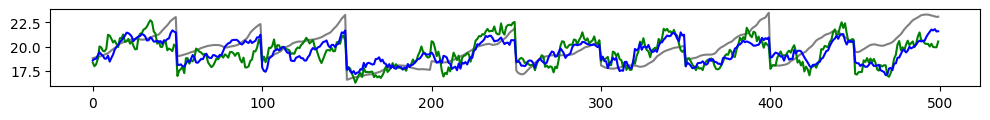

In [63]:
i = 0
plt.figure(figsize=(12,1))
plt.plot(test_Y.flatten()[i:i+500], c="gray")
plt.plot(y_pred.flatten()[i:i+500], c="g")
plt.plot(our_pred.flatten()[i:i+500], c="b")
plt.show()

In [24]:
pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
    "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    '0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a',
    '143dd7cf-6a47-47a1-906d-927ad7fe9117',
    '16799c7a-e395-435d-a4c4-a678007e1550',
    '1a60a6e1-da99-4d4e-a734-39b1d4544fad',
    '1e176f17-d00f-49bb-87ff-26d237b525f1',
    '31f3e083-a324-4b88-b0a4-7788ec37b191',
    "27bac116-ea57-4512-ad35-714a62d259cd",
    "41a3b948-13f4-4be7-90b9-150705d39005",
    "63517fd4-ece1-49eb-9259-371dc30b1dd6",
    "6fc4d73c-2071-43ec-a756-c6c6d8322c8b",
    "7d999a68-0215-4e45-8e6c-879c6ca2b771",
    "8b7c808f-763b-44c8-b273-63c6afbc6aae",
    "9117969a-3f0d-478b-ad75-98263e3bfacf"
]

#### pupil diameter

In [ ]:
R = 15
save_dir = Path("/home/yizi/side_info_decoding/saved_results/lightning_pose_res/")
behavior_type = "pupil_diameter"

for pid in pids:
    
    metrics, decoded_traces = {}, {}
    save_path = save_dir/pid/f"{behavior_type}"
    
    metrics[pid] = {}
    decoded_traces[pid] = {}
    
    metrics[pid] = {"baseline": [], "rrr": []}
    decoded_traces[pid] = {"baseline": [], "rrr": []}
    
    try:
        X_dict, Y_dict = load_data_from_pids(
            [pid],
            brain_region="all",
            behavior=behavior_type,
            data_type="all_ks",
            n_t_bins = 60,
            align_time_type="feedback_times",
            t_before=0.2,
            t_after=1.0,
            normalize_input=False
        )
    except:
        print(f"PID {pid} data missing.")
        continue
    
    X, Y = X_dict[pid], Y_dict[pid]
    offset = Y.max()
    Y /= offset
    K, C, T = X.shape
    print(f"PID: {pid} # trials: {K} # neurons {C} # time bins {T}.")
    
    counter = 0
    baseline_pred, baseline_metrics, our_pred, our_metrics = [], [], [], []
    kf = KFold(n_splits=5, shuffle=True, random_state=666)
    for train, test in kf.split(X, Y):
        
        counter += 1
        print(f"Fold {counter}:") 
        
        # baseline
        window_X = sliding_window_over_time(X, window_size=10)
        window_Y = sliding_window_over_time(Y, window_size=10)
        train_X, test_X = window_X[train], window_X[test]
        train_Y, test_Y = window_Y[train], window_Y[test]
        print("Baseline:")
        baseline_pred, baseline_metric = causal_decoder(train_X, train_Y, test_X, test_Y)
        metrics[pid]["baseline"].append(baseline_metric)
        decoded_traces[pid]["baseline"].append(baseline_pred)

        print("Reduced Rank Model:")
        rrr, losses = train_rrr(
            X = X,
            Y = Y, 
            train = train,
            test = test,
            n_r = R,
            learning_rate = 5e-3,
            n_epochs = 10000
        )
        
        plt.figure(figsize=(3,3))
        plt.plot(losses);
        
        supervised_subspace = rrr.U.detach().numpy()
        subspace_weights = rrr.V.detach().numpy()

        all_proj = X.transpose(0,-1,1) @ supervised_subspace
        weighted_proj = all_proj * subspace_weights.T
        weighted_proj = weighted_proj.transpose(0, -1, 1)

        window_X = sliding_window_over_time(weighted_proj, window_size=10)
        window_Y = sliding_window_over_time(Y, window_size=10)
        train_X, test_X = window_X[train], window_X[test]
        train_Y, test_Y = window_Y[train], window_Y[test]
        rrr_pred, rrr_metric = causal_decoder(train_X, train_Y, test_X, test_Y)
        metrics[pid]["rrr"].append(rrr_metric)
        decoded_traces[pid]["rrr"].append(rrr_pred)
        
    plt.figure(figsize=(12,1))
    plt.plot(test_Y.flatten()[:500], c="gray")
    plt.plot(baseline_pred.flatten()[:500], c="orange")
    plt.plot(rrr_pred.flatten()[:500], c="blue")
    plt.show()
        
    os.makedirs(save_path, exist_ok=True)
    np.save(save_path/"metrics.npy", metrics)
    np.save(save_path/"traces.npy", decoded_traces)
    

#### paw speed

pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 367 (active: 367)
prior for this session is not found.
found 367 trials from 17.75 to 2310.37 sec.


Compute spike count: 100%|███████████████████| 367/367 [00:02<00:00, 165.12it/s]


PID: dab512bd-a02d-4c1f-8dbc-9155a163efc0 # trials: 367 # neurons 514 # time bins 60.
Fold 1:
(367, 514, 51, 10)
(367, 51)
Baseline:
r2: -0.220 adj-r2: -0.482
Reduced Rank Model:


Train RRR:: 100%|█████████████████████████| 10000/10000 [06:14<00:00, 26.74it/s]


r2: -0.047 adj-r2: -0.168
Fold 2:
(367, 514, 51, 10)
(367, 51)
Baseline:
r2: -0.083 adj-r2: -0.190
Reduced Rank Model:


Train RRR:: 100%|█████████████████████████| 10000/10000 [06:19<00:00, 26.38it/s]


r2: 0.000 adj-r2: -0.026
Fold 3:
(367, 514, 51, 10)
(367, 51)
Baseline:
r2: -0.153 adj-r2: -0.505
Reduced Rank Model:


Train RRR:: 100%|█████████████████████████| 10000/10000 [06:00<00:00, 27.75it/s]


r2: -0.040 adj-r2: -0.270
Fold 4:
(367, 514, 51, 10)
(367, 51)
Baseline:
r2: -0.103 adj-r2: -0.190
Reduced Rank Model:


Train RRR:: 100%|█████████████████████████| 10000/10000 [06:14<00:00, 26.68it/s]


r2: -0.034 adj-r2: -0.073
Fold 5:
(367, 514, 51, 10)
(367, 51)
Baseline:
r2: -0.009 adj-r2: -0.220
Reduced Rank Model:


Train RRR:: 100%|█████████████████████████| 10000/10000 [06:01<00:00, 27.64it/s]


r2: 0.078 adj-r2: -0.028


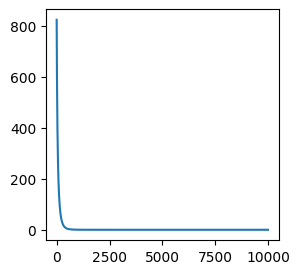

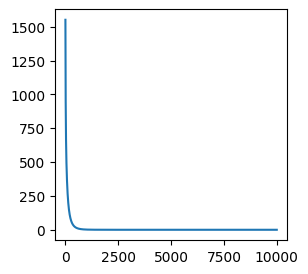

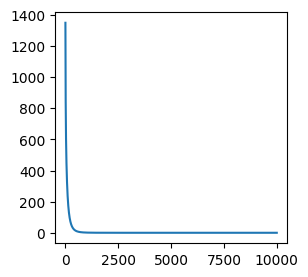

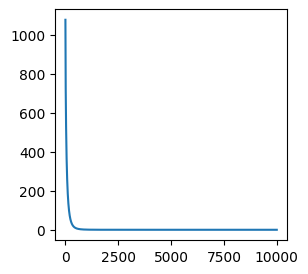

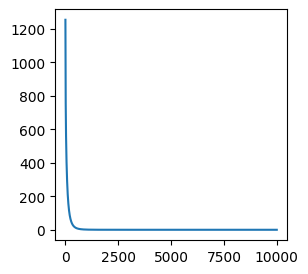

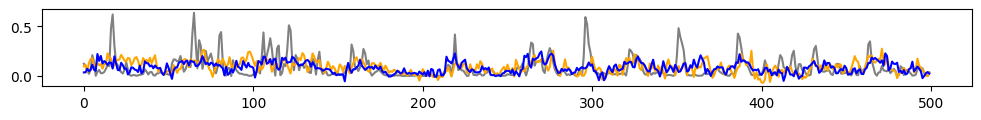

pulling data from ibl database ..
eid: db4df448-e449-4a6f-a0e7-288711e7a75a
pid: febb430e-2d50-4f83-87a0-b5ffbb9a4943
number of trials found: 350 (active: 350)
prior for this session is not found.
found 350 trials from 34.74 to 2414.77 sec.


Compute spike count: 100%|███████████████████| 350/350 [00:01<00:00, 266.24it/s]


PID: febb430e-2d50-4f83-87a0-b5ffbb9a4943 # trials: 350 # neurons 465 # time bins 60.
Fold 1:
(350, 465, 51, 10)
(350, 51)
Baseline:
r2: -0.259 adj-r2: -0.429
Reduced Rank Model:


Train RRR:: 100%|█████████████████████████| 10000/10000 [05:48<00:00, 28.67it/s]


r2: -0.037 adj-r2: -0.056
Fold 2:
(350, 465, 51, 10)
(350, 51)
Baseline:
r2: -0.275 adj-r2: -0.963
Reduced Rank Model:


Train RRR:: 100%|█████████████████████████| 10000/10000 [05:42<00:00, 29.20it/s]


r2: -0.091 adj-r2: -0.157
Fold 3:
(350, 465, 51, 10)
(350, 51)
Baseline:
r2: -0.093 adj-r2: -5.769
Reduced Rank Model:


Train RRR:: 100%|█████████████████████████| 10000/10000 [05:39<00:00, 29.49it/s]


r2: 0.027 adj-r2: -1.106
Fold 4:
(350, 465, 51, 10)
(350, 51)
Baseline:
r2: -0.096 adj-r2: -0.663
Reduced Rank Model:


Train RRR:: 100%|█████████████████████████| 10000/10000 [05:45<00:00, 28.93it/s]


r2: 0.050 adj-r2: -0.207
Fold 5:
(350, 465, 51, 10)
(350, 51)
Baseline:
r2: -0.149 adj-r2: -0.926
Reduced Rank Model:


Train RRR::  63%|████████████████▎         | 6277/10000 [03:29<02:47, 22.22it/s]

In [ ]:
R = 15
save_dir = Path("/home/yizi/side_info_decoding/saved_results/lightning_pose_res/")
behavior_type = "paw_speed"

for pid in pids:
    
    metrics, decoded_traces = {}, {}
    save_path = save_dir/pid/f"{behavior_type}"
    
    metrics[pid] = {}
    decoded_traces[pid] = {}
    
    metrics[pid] = {"baseline": [], "rrr": []}
    decoded_traces[pid] = {"baseline": [], "rrr": [], "obs": []}
    
    try:
        X_dict, Y_dict = load_data_from_pids(
            [pid],
            brain_region="all",
            behavior=behavior_type,
            data_type="all_ks",
            n_t_bins = 60,
            align_time_type="firstMovement_times",
            t_before=0.2,
            t_after=1.0,
            normalize_input=False
        )
    except:
        print(f"PID {pid} data missing.")
        continue
    
    X, Y = X_dict[pid], Y_dict[pid]
    offset = Y.max()
    Y /= offset
    K, C, T = X.shape
    print(f"PID: {pid} # trials: {K} # neurons {C} # time bins {T}.")
    
    counter = 0
    baseline_pred, baseline_metrics, our_pred, our_metrics = [], [], [], []
    kf = KFold(n_splits=5, shuffle=True, random_state=666)
    for train, test in kf.split(X, Y):
        
        counter += 1
        print(f"Fold {counter}:") 
        
        # baseline
        window_X = sliding_window_over_time(X, window_size=10)
        window_Y = sliding_window_over_time(Y, window_size=10)
        train_X, test_X = window_X[train], window_X[test]
        train_Y, test_Y = window_Y[train], window_Y[test]
        print(window_X.shape)
        print(window_Y.shape)
        print("Baseline:")
        baseline_pred, baseline_metric = causal_decoder(train_X, train_Y, test_X, test_Y)
        metrics[pid]["baseline"].append(baseline_metric)
        decoded_traces[pid]["baseline"].append(baseline_pred)
        decoded_traces[pid]["obs"].append(test_Y)

        print("Reduced Rank Model:")
        rrr, losses = train_rrr(
            X = X,
            Y = Y, 
            train = train,
            test = test,
            n_r = R,
            learning_rate = 5e-3,
            n_epochs = 10000
        )
        
        plt.figure(figsize=(3,3))
        plt.plot(losses);
        
        supervised_subspace = rrr.U.detach().numpy()
        subspace_weights = rrr.V.detach().numpy()

        all_proj = X.transpose(0,-1,1) @ supervised_subspace
        weighted_proj = all_proj * subspace_weights.T
        weighted_proj = weighted_proj.transpose(0, -1, 1)

        window_X = sliding_window_over_time(weighted_proj, window_size=10)
        window_Y = sliding_window_over_time(Y, window_size=10)
        train_X, test_X = window_X[train], window_X[test]
        train_Y, test_Y = window_Y[train], window_Y[test]
        rrr_pred, rrr_metric = causal_decoder(train_X, train_Y, test_X, test_Y)
        metrics[pid]["rrr"].append(rrr_metric)
        decoded_traces[pid]["rrr"].append(rrr_pred)
        
    plt.figure(figsize=(12,1))
    plt.plot(test_Y.flatten()[:500], c="gray")
    plt.plot(baseline_pred.flatten()[:500], c="orange")
    plt.plot(rrr_pred.flatten()[:500], c="blue")
    plt.show()
        
    os.makedirs(save_path, exist_ok=True)
    np.save(save_path/"metrics.npy", metrics)
    np.save(save_path/"traces.npy", decoded_traces)
    